## **Task 2g: Next Generation Vision Transformers for End-to-End Mass Regression and Classification**
**Description**:

- Train a Resnet15 model using Self-Supervised Learning using a custom loss/training scheme defined in any of the papers ([MoCo](https://arxiv.org/abs/1911.05722), [SimCLR](https://arxiv.org/abs/2002.05709), [OBoW](https://arxiv.org/abs/2012.11552), [Barlow Twins](https://arxiv.org/abs/2103.03230) or [VICReg](https://arxiv.org/abs/2105.04906)) on the provided unlabelled dataset.
- Finetune the model for both regression and classification using the low learning rate on the provided labelled dataset and compare the results with a model trained from scratch.

Please train your finetuned and scratch model on 80% of the data (Labelled) and evaluate on the remaining 20%. Please make sure not to overfit on the test dataset - it will be checked with an independent sample. Please provide a **Jupyter notebook** that shows your solution along with the model weights.

**Datasets (Unlabelled/Pretraining Stage and Labelled/Finetuning Stage)**:

https://cernbox.cern.ch/s/e3pqxcIznqdYyRv

In [ ]:
# Default libraries
import sys
import pathlib
import warnings

# Data preprocessing & visualization
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Deep learning
import torch
from torch import nn, optim, Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import SequentialLR, LambdaLR, CosineAnnealingWarmRestarts
from torchvision import transforms

# Helper functions & models
sys.path.append('../')
from utils.data_processing import VICRegUnlabelledDataset
from utils.vic_reg import VICRegularizationLoss, LARS
from utils.training import (
    pretrain_VICReg, plot_pretrain_VICReg_loss,
    load_checkpoint, plot_history,
    train_and_validate, accuracy_metric_bce, test
)
from models.resnet15 import ResNet15, ResNet15WithExpander

# Settings
warnings.filterwarnings('ignore')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **1. Data Exploration**

Available keys: ['jet']
Dataset shape: (60000, 125, 125, 8)
Image type: <class 'numpy.ndarray'>


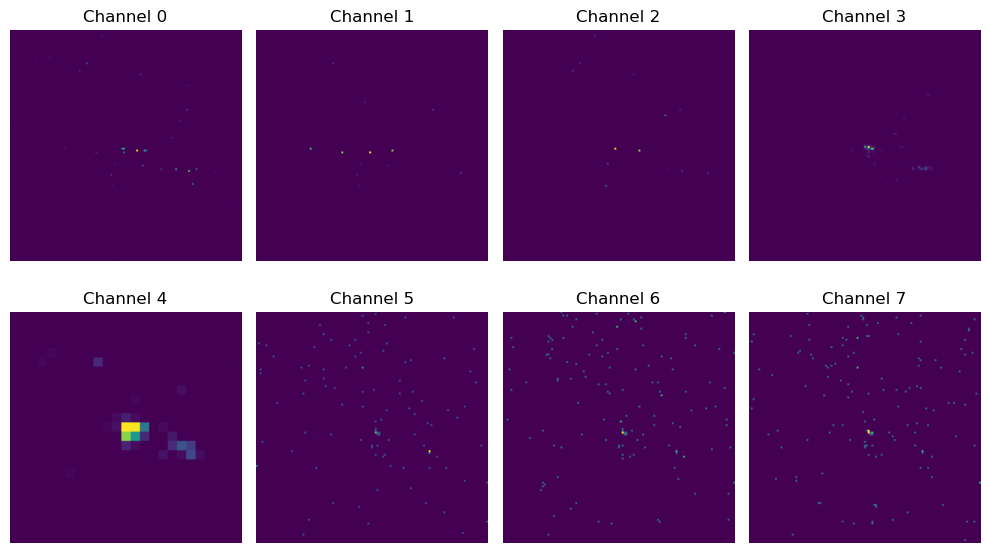

In [2]:
# Path to datasets
labelled_dataset_path = pathlib.Path('../data/Dataset_Specific_labelled.h5')
unlabelled_dataset_path = pathlib.Path('../data/Dataset_Specific_Unlabelled.h5')

# Open the HDF5 file in read mode
with h5py.File(unlabelled_dataset_path, 'r') as f:
    print("Available keys:", list(f.keys()))
    
    # Access the 'jet' data (60000, 125, 125, 8)
    dataset = f['jet']
    print("Dataset shape:", dataset.shape)

    # Extract one image
    image = dataset[0]  # (125, 125, 8)
    print("Image type:", type(image))

# Create a figure to display the 8 channels
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()

# Plot each of the 8 channels separately
for i in range(8):
    axes[i].imshow(image[:, :, i], cmap='viridis')
    axes[i].set_title(f"Channel {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### **2. Self-Supervised Learning with VICReg**

In [3]:
# Function to load the unlabelled dataset
def load_unlabelled_h5_data(filepath: str) -> np.ndarray:
    with h5py.File(filepath, 'r') as f:
        data = f['jet'][:]
    return data

# Load the unlabelled data
unlabelled_data = load_unlabelled_h5_data(str(unlabelled_dataset_path))
unlabelled_data.shape

(60000, 125, 125, 8)

In [ ]:
# # Compute mean and standard deviation per channel for normalization
# mean = unlabelled_data.mean(axis=(0, 1, 2))
# std = unlabelled_data.std(axis=(0, 1, 2))

# print("Mean per channel:", mean)
# print("Std per channel:", std)

Mean per channel: [0.07848097 0.08429243 0.05751758 0.12098689 1.2899013  1.1099757
 1.15771    1.1159292 ]
Std per channel: [ 3.0687237  3.2782698  2.9819856  3.2468746 13.511705  12.441227
 12.12112   11.721005 ]


In [4]:
# Variables for mean and std
mean = [
    0.07848097, 0.08429243, 0.05751758, 0.12098689,
    1.2899013, 1.1099757, 1.15771, 1.1159292
]
std = [
    3.0687237, 3.2782698, 2.9819856, 3.2468746,
    13.511705, 12.441227, 12.12112, 11.721005
]

In [5]:
# Large batch size for VICReg
batch_size = 1024

# Transformations for 8-channel images
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.permute(2, 0, 1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=23)], p=0.5),
    transforms.Normalize(mean=mean, std=std)
])

# Create Dataset and DataLoader for unlabelled data
unlabelled_dataset = VICRegUnlabelledDataset(unlabelled_data, transform=transform)
# unlabelled_dataset = VICRegLazyLoadingDataset(str(unlabelled_dataset_path), transform=transform)  # lazy-loading
ssl_loader = DataLoader(unlabelled_dataset, batch_size=batch_size)
del unlabelled_data

**Data Augmentation Choices**:
- Here, `batch_size` should be $2048$ according to [Goyal et al. (2017)](#goyal-et-al-2017). But due to memory limitation, I halved it and did not resize the image to $(224, 224)$.
- Most image transformations here follow [Bardes et al. (2021)](#bardes-et-al-2021), but $8$-channel images made the color transformations not possible (require shape $[..., 1 \, or \, 3, H, W]$).
- I made a mistake where I normalized by mean and standard deviation across the batch. Because all images are min-max normalized from $0$ to $255.0$, the correct method is to divide the pixel values by $255.0$.

In [6]:
# Initialize the model
model = ResNet15WithExpander(
    in_channels=8,
    inplanes=64,
    planes=64,
    layers=[2, 2, 3],
    representation_dim=256,
    hidden_dim=1024
).to(device)
model

ResNet15WithExpander(
  (resnet): ResNet15(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

**Model Choices**:

- The ResNet15 here is the same as the one used in Task 1 where I added a linear layer after the global maxpool compared the original of [Andrews et al. (2020)](#andrews-et-al-2020).
- [Bardes et al. (2021)](#bardes-et-al-2021) suggested that the Expander is "composed of two fully-connected layers with batch normalization (BN) [Ioffe & Szegedy (2015)](#ioffe--szegedy-2015) and ReLU, and a third linear layer. The sizes of all $3$ layers were set to $8192$." However, I scaled the representations $Y$, $Y'$ to $256$ and the final embeddings $Z$, $Z'$ to $1024$ to be more suitable with ResNet15.

In [7]:
# Hyperparameters for pretraining
base_lr = 0.2
lr = batch_size / 256.0 * base_lr
final_lr = 0.0002
weight_decay = 1e-6
num_epochs = 300
warmup_epochs = 10
criterion = VICRegularizationLoss(gamma=1.0, epsilon=1e-4, lambda_=25.0, mu=25.0, nu=1.0)
base_optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
optimizer = LARS(base_optimizer, eps=1e-8, eta=1e-3)
warmup_scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda epoch: (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1
)
cosine_scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=num_epochs - warmup_epochs,
    T_mult=1,
    eta_min=final_lr
)
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_epochs]
)
pretrain_history = {
    'epoch': [],
    'VICReg_loss': [],
    'variance_loss': [],
    'invariance_loss': [],
    'covariance_loss': []
}
checkpoint_path = '../model-checkpoints/Task2g_VICReg_checkpoint.pt'
best_model_path = '../model-checkpoints/Task2g_VICReg_resnet15.pt'

**Hyperparameter Choices**:

- [Bardes et al. (2021)](#bardes-et-al-2021) proposed `gamma=1.0`, `epsilon=1e-4`, `lambda_=25.0`, `mu=25.0`, `nu=1.0` for the VIC Regularization.
- The Layer-wise Adaptive Rate Scaling (LARS) is from [You et al. (2017)](#you-et-al-2017), where they used `momentum=0.9` for SGD and LARS coefficient $\eta=0.001$.
- The choices for `base_lr`, `lr`, `weight_decay` are from [Goyal et al. (2017)](#goyal-et-al-2017). `num_epochs` should be $1000$ here, but $300$ should be sufficient for this problem.
- The settings of the scheduler are from [Loshchilov & Hutter (2016)](#loshchilov--hutter-2016).

In [ ]:
# Self-supervised training
pretrain_history, model = pretrain_VICReg(
    model=model,
    train_loader=ssl_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    history=pretrain_history,
    checkpoint_path=checkpoint_path,
    best_model_path=best_model_path
)

Pretrain Epoch [1/300], std_loss=1.4870, sim_loss=0.0722, cov_loss=0.9369 , VICReg Loss: 39.9172
Pretrain Epoch [2/300], std_loss=1.1690, sim_loss=0.0537, cov_loss=3.6567 , VICReg Loss: 34.2249
Pretrain Epoch [3/300], std_loss=0.9004, sim_loss=0.0296, cov_loss=5.5952 , VICReg Loss: 28.8450
Pretrain Epoch [4/300], std_loss=0.6669, sim_loss=0.0275, cov_loss=7.0296 , VICReg Loss: 24.3896
Pretrain Epoch [5/300], std_loss=0.4431, sim_loss=0.0301, cov_loss=8.3680 , VICReg Loss: 20.1973
Pretrain Epoch [6/300], std_loss=0.2123, sim_loss=0.0354, cov_loss=9.8018 , VICReg Loss: 15.9961
Pretrain Epoch [7/300], std_loss=0.0737, sim_loss=0.0389, cov_loss=9.6096 , VICReg Loss: 12.4253
Pretrain Epoch [8/300], std_loss=0.0432, sim_loss=0.0372, cov_loss=8.0390 , VICReg Loss: 10.0491
Pretrain Epoch [9/300], std_loss=0.0297, sim_loss=0.0337, cov_loss=6.8781 , VICReg Loss: 8.4616
Pretrain Epoch [10/300], std_loss=0.0222, sim_loss=0.0300, cov_loss=6.0530 , VICReg Loss: 7.3569
Pretrain Epoch [11/300], std_lo

({'epoch': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   134,
   135,
   136,
   13

- I forgot to assign variable during the first run, so it output the history and the trained model here. And there was also an extra space behind a comma in the print statement.

In [ ]:
# Load the checkpoint to resume training
start_epoch, pretrain_history, model = load_checkpoint(
    checkpoint_path=checkpoint_path,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler
)
print(f"Contine training from epoch {start_epoch}")

Contine training from epoch 184


In [ ]:
# Continue training
pretrain_history, model = pretrain_VICReg(
    model=model,
    train_loader=ssl_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    start_epoch=start_epoch,
    history=pretrain_history,
    checkpoint_path=checkpoint_path,
    best_model_path=best_model_path
)

Pretrain Epoch [184/300], std_loss=0.0025, sim_loss=0.0020, cov_loss=1.7043, VICReg Loss: 1.8173
Pretrain Epoch [185/300], std_loss=0.0027, sim_loss=0.0020, cov_loss=1.6914, VICReg Loss: 1.8092
Pretrain Epoch [186/300], std_loss=0.0025, sim_loss=0.0019, cov_loss=1.6824, VICReg Loss: 1.7925
Pretrain Epoch [187/300], std_loss=0.0020, sim_loss=0.0020, cov_loss=1.6759, VICReg Loss: 1.7760
Pretrain Epoch [188/300], std_loss=0.0022, sim_loss=0.0020, cov_loss=1.6770, VICReg Loss: 1.7815
Pretrain Epoch [189/300], std_loss=0.0023, sim_loss=0.0020, cov_loss=1.6797, VICReg Loss: 1.7862
Pretrain Epoch [190/300], std_loss=0.0020, sim_loss=0.0020, cov_loss=1.6716, VICReg Loss: 1.7707
Pretrain Epoch [191/300], std_loss=0.0024, sim_loss=0.0020, cov_loss=1.6725, VICReg Loss: 1.7808
Pretrain Epoch [192/300], std_loss=0.0022, sim_loss=0.0020, cov_loss=1.6727, VICReg Loss: 1.7778
Pretrain Epoch [193/300], std_loss=0.0022, sim_loss=0.0019, cov_loss=1.6728, VICReg Loss: 1.7762
Pretrain Epoch [194/300], std_

- The kernal unexpectedly crashed at epoch 278.

In [ ]:
# Load the checkpoint to resume training
start_epoch, pretrain_history, model = load_checkpoint(
    checkpoint_path=checkpoint_path,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler
)
print(f"Continue training from epoch {start_epoch}")

Continue training from epoch 279


In [18]:
# Continue training
pretrain_history, model = pretrain_VICReg(
    model=model,
    train_loader=ssl_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    start_epoch=start_epoch,
    history=pretrain_history,
    checkpoint_path=checkpoint_path,
    best_model_path=best_model_path
)

Pretrain Epoch [279/300], std_loss=0.0002, sim_loss=0.0015, cov_loss=1.5277, VICReg Loss: 1.5710
Pretrain Epoch [280/300], std_loss=0.0004, sim_loss=0.0015, cov_loss=1.5269, VICReg Loss: 1.5748
Pretrain Epoch [281/300], std_loss=0.0004, sim_loss=0.0015, cov_loss=1.5265, VICReg Loss: 1.5739
Pretrain Epoch [282/300], std_loss=0.0003, sim_loss=0.0015, cov_loss=1.5261, VICReg Loss: 1.5724
Pretrain Epoch [283/300], std_loss=0.0003, sim_loss=0.0015, cov_loss=1.5255, VICReg Loss: 1.5716
Pretrain Epoch [284/300], std_loss=0.0003, sim_loss=0.0015, cov_loss=1.5250, VICReg Loss: 1.5705
Pretrain Epoch [285/300], std_loss=0.0003, sim_loss=0.0015, cov_loss=1.5245, VICReg Loss: 1.5693
Pretrain Epoch [286/300], std_loss=0.0003, sim_loss=0.0015, cov_loss=1.5238, VICReg Loss: 1.5684
Pretrain Epoch [287/300], std_loss=0.0002, sim_loss=0.0015, cov_loss=1.5234, VICReg Loss: 1.5674
Pretrain Epoch [288/300], std_loss=0.0002, sim_loss=0.0015, cov_loss=1.5233, VICReg Loss: 1.5666
Pretrain Epoch [289/300], std_

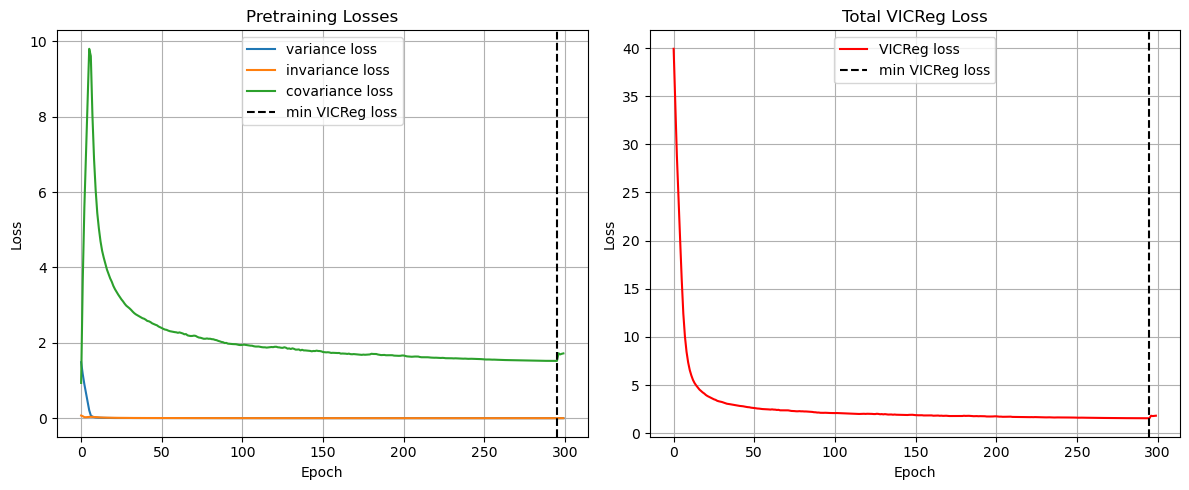

In [10]:
# Visualize the pretraining loss
plot_pretrain_VICReg_loss(pretrain_history)

In [11]:
# Clear memory
del unlabelled_dataset
del ssl_loader

### **3. Fine-Tuning for Downstream Tasks**

#### **a) Prepare the Labelled Data**

In [12]:
# Function to load the labelled dataset
def load_labelled_h5_data(filepath: str, start: int, stop: int) -> tuple[np.ndarray, np.ndarray]:
    with h5py.File(filepath, 'r') as f:
        data = f['jet'][start:stop]
        labels = f['Y'][start:stop]
    return data, labels

# Train, validation, and test sets ratio
num_samples = 10_000
train_size = int(0.7 * num_samples)
valid_size = int(0.1 * num_samples)
test_size = int(0.2 * num_samples)

In [13]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
X_train, y_train = load_labelled_h5_data(labelled_dataset_path, train_start, train_stop)

# Set range of validation set
valid_start, valid_stop = train_stop, train_stop + valid_size
assert valid_stop > valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_labelled_h5_data(labelled_dataset_path, valid_start, valid_stop)

# Set range of test set
test_start, test_stop = valid_stop, valid_stop + test_size
assert test_stop > test_start
assert test_start >= valid_stop
X_test, y_test = load_labelled_h5_data(labelled_dataset_path, test_start, test_stop)\

# Permute the indices for PyTorch format
X_train = np.moveaxis(X_train, 3, 1)
X_valid = np.moveaxis(X_valid, 3, 1)
X_test = np.moveaxis(X_test, 3, 1)

In [14]:
# Construct the dataset and dataloader
class LabelledDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = torch.from_numpy(y.copy())
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]

        if self.transform:
            x = self.transform(x)
        else:
            x = torch.from_numpy(x.copy()).float()

        return x, self.y[idx].squeeze()
    
# Transformations for 8-channel images
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x).float()),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=23)], p=0.5),
    transforms.Normalize(mean=mean, std=std)
])

# Datasets and dataloaders
train_dataset = LabelledDataset(X_train, y_train, transform=transform)
valid_dataset = LabelledDataset(X_valid, y_valid, transform=transform)
test_dataset = LabelledDataset(X_test, y_test, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# ResNet15 architecture for downstream tasks
class DownstreamResNet15(nn.Module):
    def __init__(
        self,
        resnet: nn.Module,
        num_classes: int = 1,
        representation_dim: int = 256,
        task: str = 'classification'
    ):
        super(DownstreamResNet15, self).__init__()
        self.task = task
        self.resnet = resnet
        self.fc = nn.Linear(representation_dim, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        x = self.resnet(x)
        x = self.fc(x)

        if self.task == 'classification':
            x = x.squeeze(-1)  # (batch_size,) raw logits for BCEWithLogitsLoss

        return x

#### **b) Classification**

**ResNet15 with VICReg**

In [16]:
# Load the checkpoint with the best validation loss and discard the expander
model.load_state_dict(torch.load(best_model_path))
pretrained_resnet15 = model.resnet

In [17]:
# Initialize the ResNet15 model for classification
cls_model = DownstreamResNet15(
    resnet=pretrained_resnet15,
    num_classes=1,  # for BCEWithLogitsLoss
    representation_dim=256,
    task='classification'
).to(device)
cls_model

DownstreamResNet15(
  (resnet): ResNet15(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [18]:
# Model hyperparameters
lr_init = 1e-5  # low learning rate for fine-tuning
num_epochs = 100
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cls_model.parameters(), lr=lr_init, eps=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
fine_tuned_cls_resnet15_save_path = '../model-checkpoints/Task2g_fine_tuned_cls_resnet15.pt'

In [19]:
# Fine-tune the ResNet15
history, cls_model = train_and_validate(
    model=cls_model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    metric=accuracy_metric_bce,
    scheduler=scheduler,
    num_epochs=num_epochs,
    save_path=fine_tuned_cls_resnet15_save_path,
    save_strategy='val_loss'  # can be 'val_loss' or 'val_acc'
)

Epoch [1/100], Train Loss: 1.2143, Train Metric: 0.5221, Val Loss: 0.8575, Val Metric: 0.5951
Epoch [2/100], Train Loss: 0.8052, Train Metric: 0.6298, Val Loss: 0.6960, Val Metric: 0.6681
Epoch [3/100], Train Loss: 0.6734, Train Metric: 0.6947, Val Loss: 0.6135, Val Metric: 0.7055
Epoch [4/100], Train Loss: 0.5968, Train Metric: 0.7329, Val Loss: 0.5557, Val Metric: 0.7380
Epoch [5/100], Train Loss: 0.5394, Train Metric: 0.7568, Val Loss: 0.5139, Val Metric: 0.7552
Epoch [6/100], Train Loss: 0.4966, Train Metric: 0.7815, Val Loss: 0.4846, Val Metric: 0.7665
Epoch [7/100], Train Loss: 0.4631, Train Metric: 0.7968, Val Loss: 0.4571, Val Metric: 0.7856
Epoch [8/100], Train Loss: 0.4410, Train Metric: 0.8106, Val Loss: 0.4342, Val Metric: 0.8006
Epoch [9/100], Train Loss: 0.4155, Train Metric: 0.8225, Val Loss: 0.4194, Val Metric: 0.8038
Epoch [10/100], Train Loss: 0.4005, Train Metric: 0.8282, Val Loss: 0.4045, Val Metric: 0.8126
Epoch [11/100], Train Loss: 0.3844, Train Metric: 0.8325, V

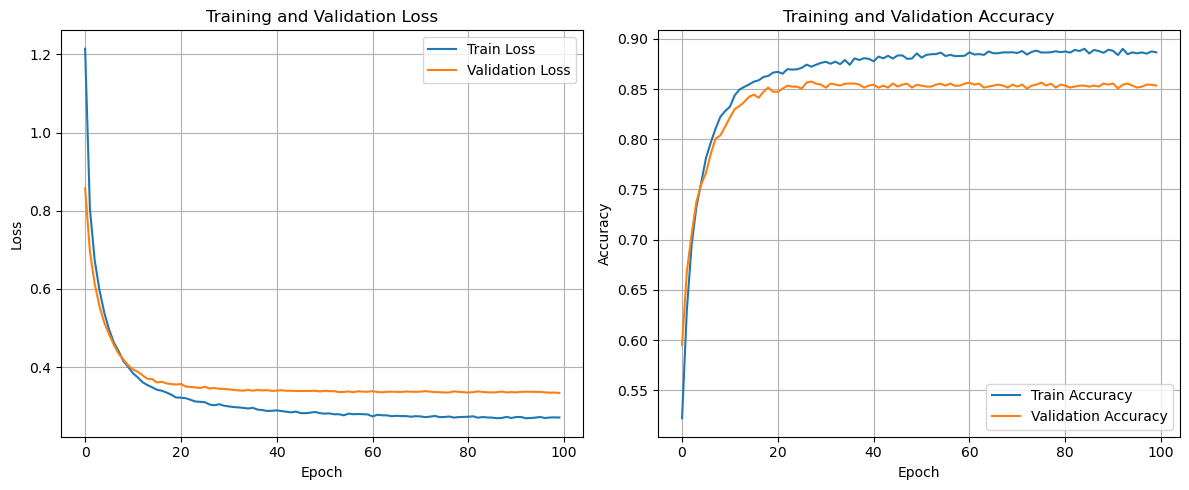

In [20]:
# Plot the training history
plot_history(history)

In [21]:
# Load the weights with the best validation loss for the classification head
cls_model.load_state_dict(torch.load(fine_tuned_cls_resnet15_save_path))

<All keys matched successfully>

Test Loss: 0.2992, Test Metric: 0.8717, ROC AUC: 0.9427


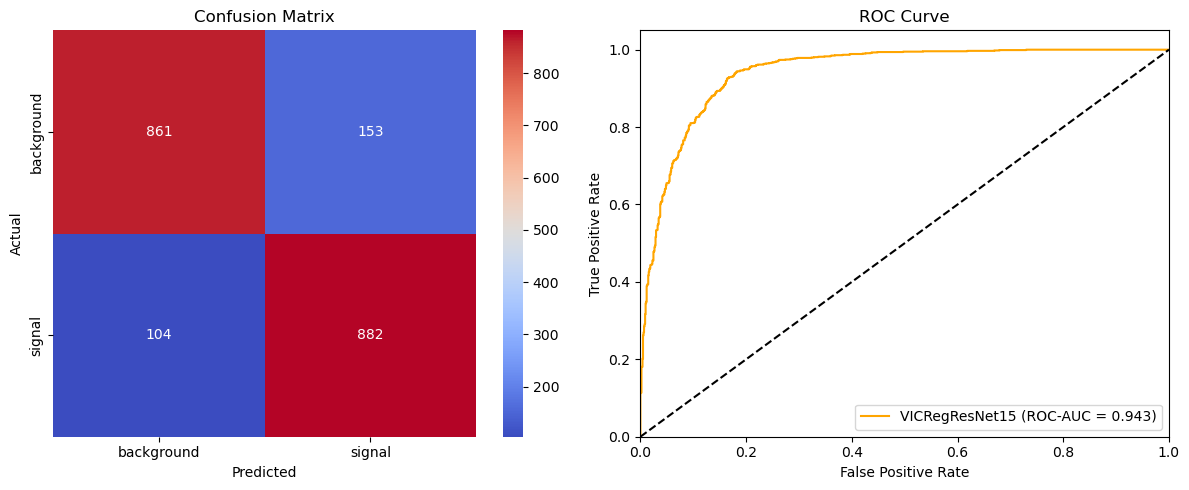

In [22]:
# Evaluate on the test set
test(
    model=cls_model,
    test_loader=test_loader,
    criterion=criterion,
    metric=accuracy_metric_bce,
    loss_type='bce',
    model_name='VICRegResNet15',
    classes=['background', 'signal']
)

**ResNet15 from Scratch**

In [22]:
# Initialize a ResNet15 from scratch
resnet15 = ResNet15(
    num_classes=256,  # representation dimension
    in_channels=8,
    inplanes=64,
    planes=64,
    layers=[2, 2, 3],
).to(device)

In [23]:
# Initialize the ResNet15 model for classification
cls_model = DownstreamResNet15(
    resnet=resnet15,
    num_classes=1,  # for BCEWithLogitsLoss
    representation_dim=256,
    task='classification'
).to(device)
cls_model

DownstreamResNet15(
  (resnet): ResNet15(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [24]:
# Model hyperparameters
lr_init = 1e-5
num_epochs = 100
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cls_model.parameters(), lr=lr_init, eps=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
cls_resnet15_save_path = '../model-checkpoints/Task2g_cls_resnet15.pt'

In [25]:
# Train the ResNet15 from scratch
history, cls_model = train_and_validate(
    model=cls_model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    metric=accuracy_metric_bce,
    scheduler=scheduler,
    num_epochs=num_epochs,
    save_path=cls_resnet15_save_path,
    save_strategy='val_loss'  # can be 'val_loss' or 'val_acc'
)

Epoch [1/100], Train Loss: 0.7136, Train Metric: 0.5581, Val Loss: 0.6685, Val Metric: 0.5923
Epoch [2/100], Train Loss: 0.5948, Train Metric: 0.6902, Val Loss: 0.6028, Val Metric: 0.6947
Epoch [3/100], Train Loss: 0.5518, Train Metric: 0.7400, Val Loss: 0.5739, Val Metric: 0.7207
Epoch [4/100], Train Loss: 0.5145, Train Metric: 0.7572, Val Loss: 0.5672, Val Metric: 0.7302
Epoch [5/100], Train Loss: 0.4900, Train Metric: 0.7818, Val Loss: 0.5334, Val Metric: 0.7591
Epoch [6/100], Train Loss: 0.4667, Train Metric: 0.7935, Val Loss: 0.5343, Val Metric: 0.7507
Epoch [7/100], Train Loss: 0.4518, Train Metric: 0.8041, Val Loss: 0.5173, Val Metric: 0.7607
Epoch [8/100], Train Loss: 0.4282, Train Metric: 0.8183, Val Loss: 0.5021, Val Metric: 0.7729
Epoch [9/100], Train Loss: 0.4157, Train Metric: 0.8289, Val Loss: 0.4955, Val Metric: 0.7704
Epoch [10/100], Train Loss: 0.4088, Train Metric: 0.8317, Val Loss: 0.4850, Val Metric: 0.7824
Epoch [11/100], Train Loss: 0.3890, Train Metric: 0.8401, V

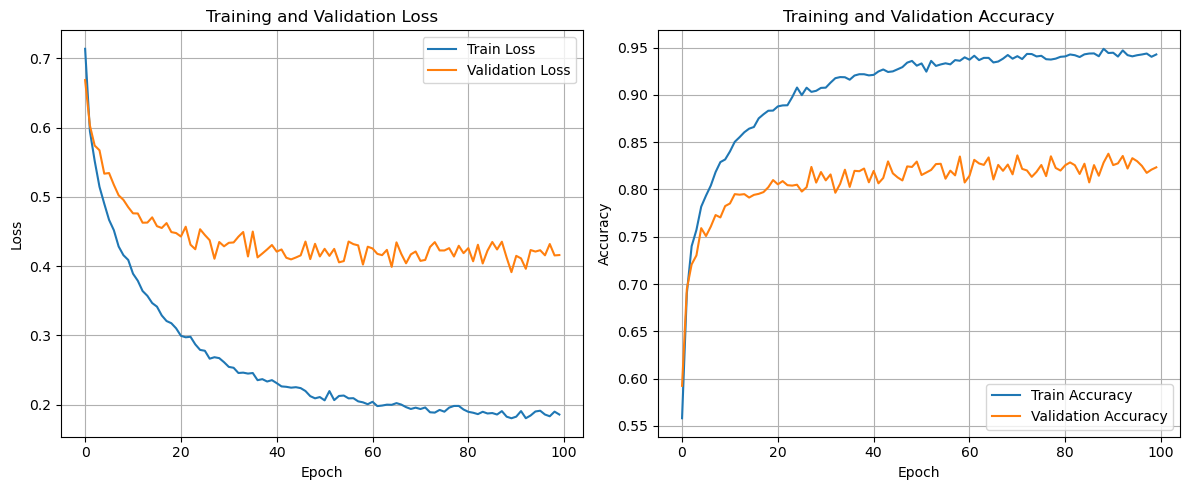

In [26]:
# Plot the training history
plot_history(history)

In [27]:
# Load the weights with the best validation loss for the classification head
cls_model.load_state_dict(torch.load(cls_resnet15_save_path))

<All keys matched successfully>

Test Loss: 0.4246, Test Metric: 0.8239, ROC AUC: 0.8966


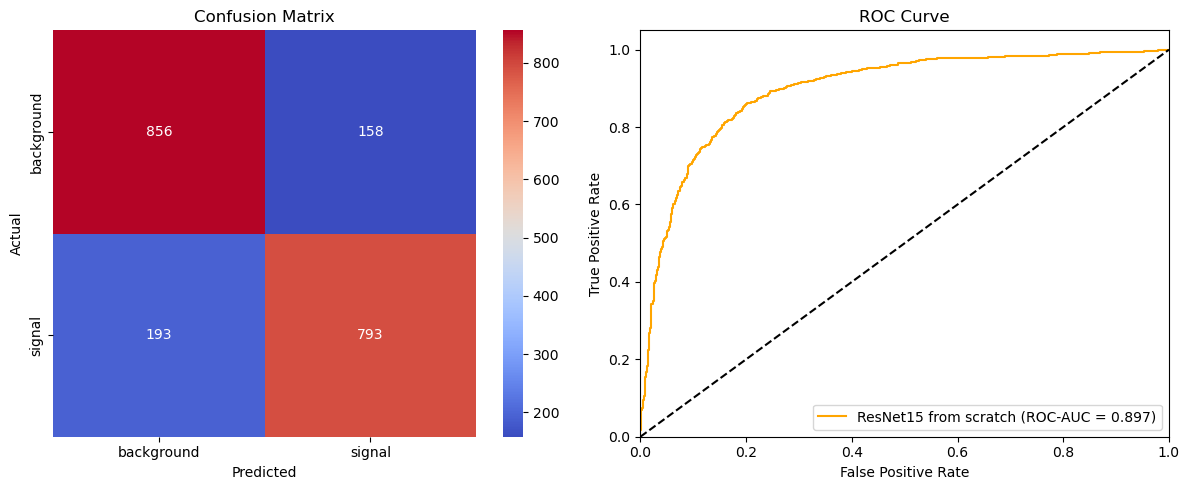

In [28]:
# Evaluate on the test set
test(
    model=cls_model,
    test_loader=test_loader,
    criterion=criterion,
    metric=accuracy_metric_bce,
    loss_type='bce',
    model_name='ResNet15 from scratch',
    classes=['background', 'signal']
)

**Citations**:

<a id="andrews-et-al-2020"></a>
Andrews, M., Paulini, M., Gleyzer, S., & Poczos, B. (2020). [End-to-end physics event classification with CMS open data: Applying image-based deep learning to detector data for the direct classification of collision events at the LHC](https://link.springer.com/article/10.1007/s41781-020-00038-8). *Computing and Software for Big Science*, 4, 1-14.

<a id="bardes-et-al-2021"></a>
Bardes, A., Ponce, J., & LeCun, Y. (2021). [Vicreg: Variance-invariance-covariance regularization for self-supervised learning](https://arxiv.org/abs/2105.04906). *arXiv preprint arXiv:2105.04906*.

<a id="goyal-et-al-2017"></a>
Goyal, P., Dollár, P., Girshick, R., Noordhuis, P., Wesolowski, L., Kyrola, A., ... & He, K. (2017). [Accurate, large minibatch sgd: Training imagenet in 1 hour](https://arxiv.org/abs/1706.02677). *arXiv preprint arXiv:1706.02677*.

<a id="ioffe--szegedy-2015"></a>
Ioffe, S., & Szegedy, C. (2015, June). [Batch normalization: Accelerating deep network training by reducing internal covariate shift](https://proceedings.mlr.press/v37/ioffe15.html). In *International conference on machine learning* (pp. 448-456). pmlr.

<a id="loshchilov--hutter-2016"></a>
Loshchilov, I., & Hutter, F. (2016). [Sgdr: Stochastic gradient descent with warm restarts](https://arxiv.org/abs/1608.03983). *arXiv preprint arXiv:1608.03983*.

<a id="park-et-al-2019"></a>
Park, C., Lee, H., Jeong, M., Baek, W., & Kim, C. (2019). [torchlars: A LARS implementation in PyTorch](https://github.com/kakaobrain/torchlars)

<a id="you-et-al-2017"></a>
You, Y., Gitman, I., & Ginsburg, B. (2017). [Large batch training of convolutional networks](https://arxiv.org/abs/1708.03888). *arXiv preprint arXiv:1708.03888*.